In [1]:
#!/usr/bin/env python
# coding: utf-8

# Deep Deterministic Policy Gradient for Portfolio Management
#  
# 1. We have already overfit the model by training on 16 stocks using 3 years of training data 
# Training was done by running stock_trading.py using DDPG lstm 3 steps window on these 16 stocks
# ['AAPL', 'ATVI', 'CMCSA', 'COST', 'CSX', 'DISH', 'EA', 'EBAY', 'FB', 'GOOGL', 'HAS', 'ILMN', 'INTC', 'MAR', 'REGN', 'SBUX']
#
# 2. We then load a second dataset with different 16 stocks OHLC data
# 3. We test the model performance on the new stocks data (not seen during training) for the training time period
# 4. We then test the model performance on the new stocks data for the testing time period (neither was seen during training)

In [1]:


import os
#from google.colab import drive
#drive.mount('/content/drive')
os.environ["KERAS_BACKEND"] = "theano"
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
#### for compatible with python 3
#from __future__ import print_function
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')



In [3]:

# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
get_ipython().run_line_magic('matplotlib', 'inline')

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
get_ipython().run_line_magic('config', "InlineBackend.figure_formats = {'png', 'retina'}")
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# configure Seaborn settings 
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'EFEFD5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()


Loading BokehJS ...

In [4]:


# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3


In [5]:

# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]
print( abbreviation)
print("target_history.shape stocks, steps, OHLC", target_history.shape)
print("testing_history.shape stocks, steps, OHLC", testing_history.shape)


['AAPL', 'ATVI', 'CMCSA', 'COST', 'CSX', 'DISH', 'EA', 'EBAY', 'FB', 'GOOGL', 'HAS', 'ILMN', 'INTC', 'MAR', 'REGN', 'SBUX']
target_history.shape stocks, steps, OHLC (16, 1095, 4)
testing_history.shape stocks, steps, OHLC (16, 730, 4)


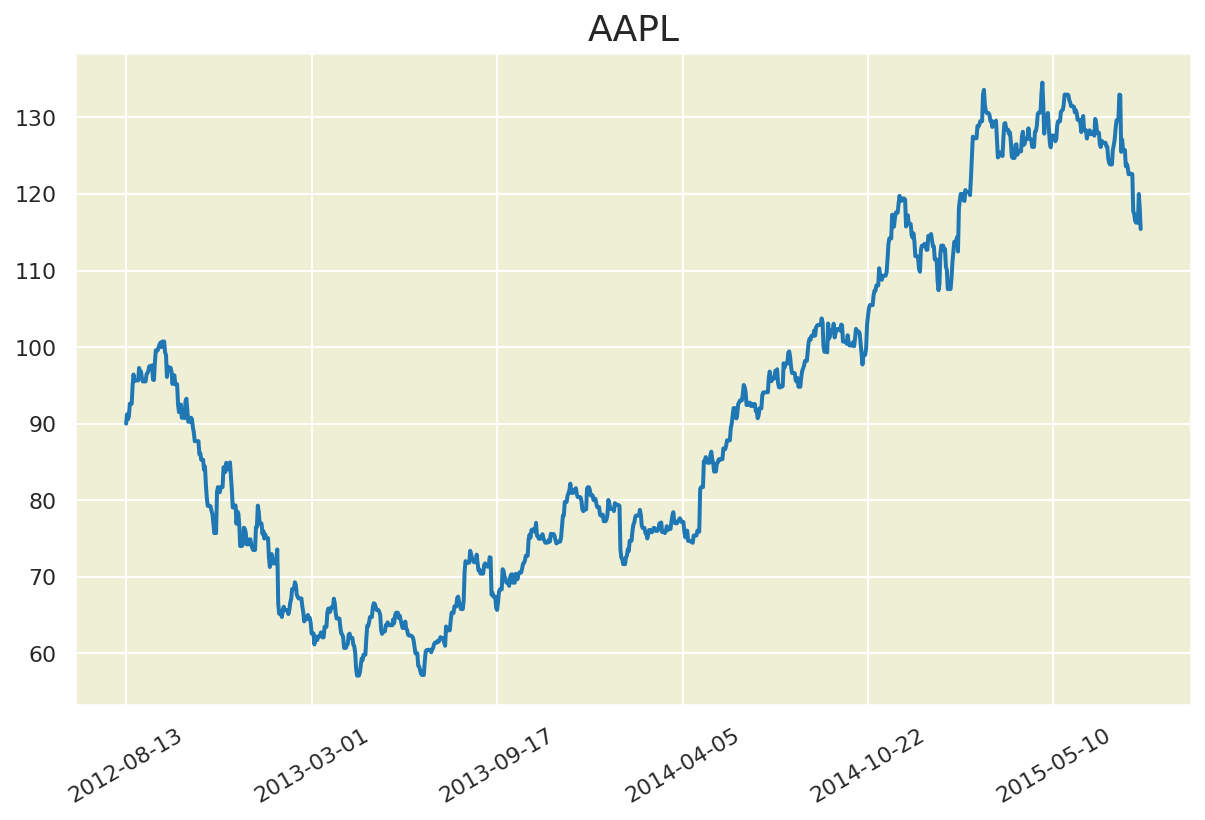

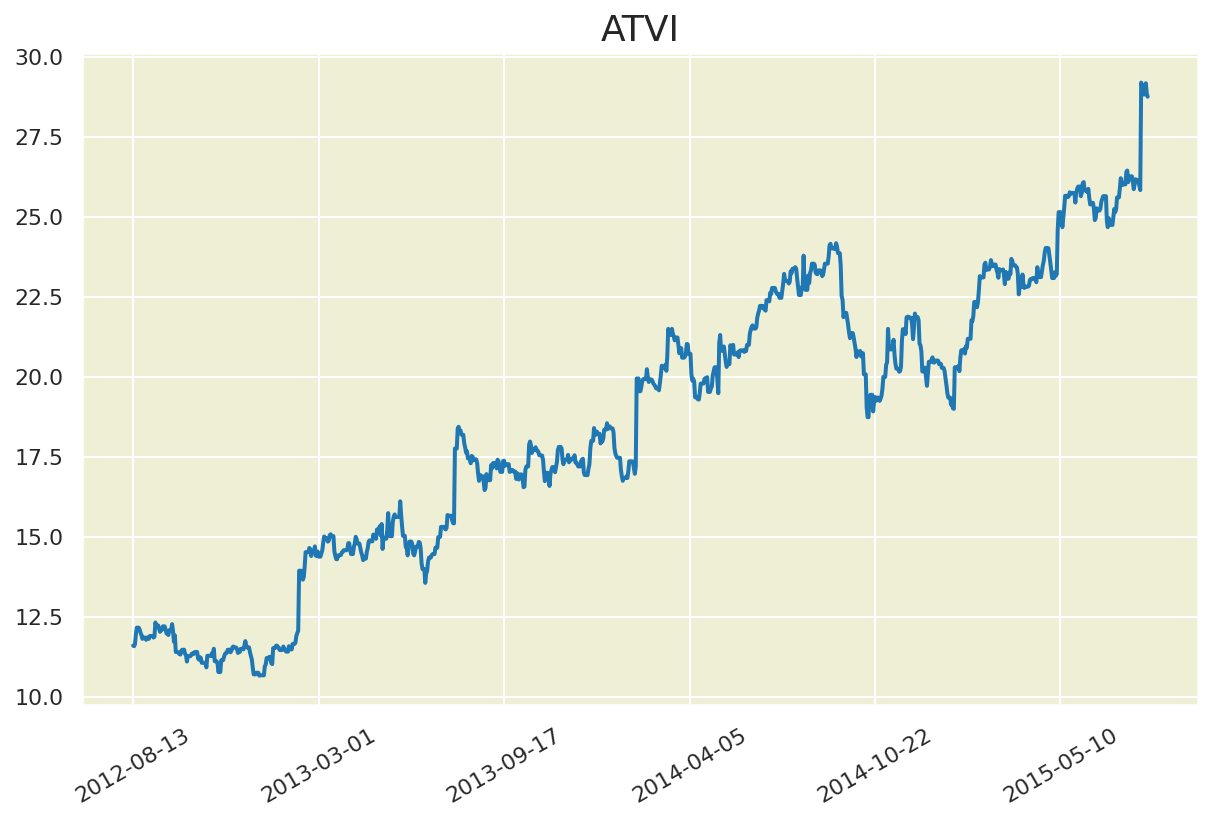

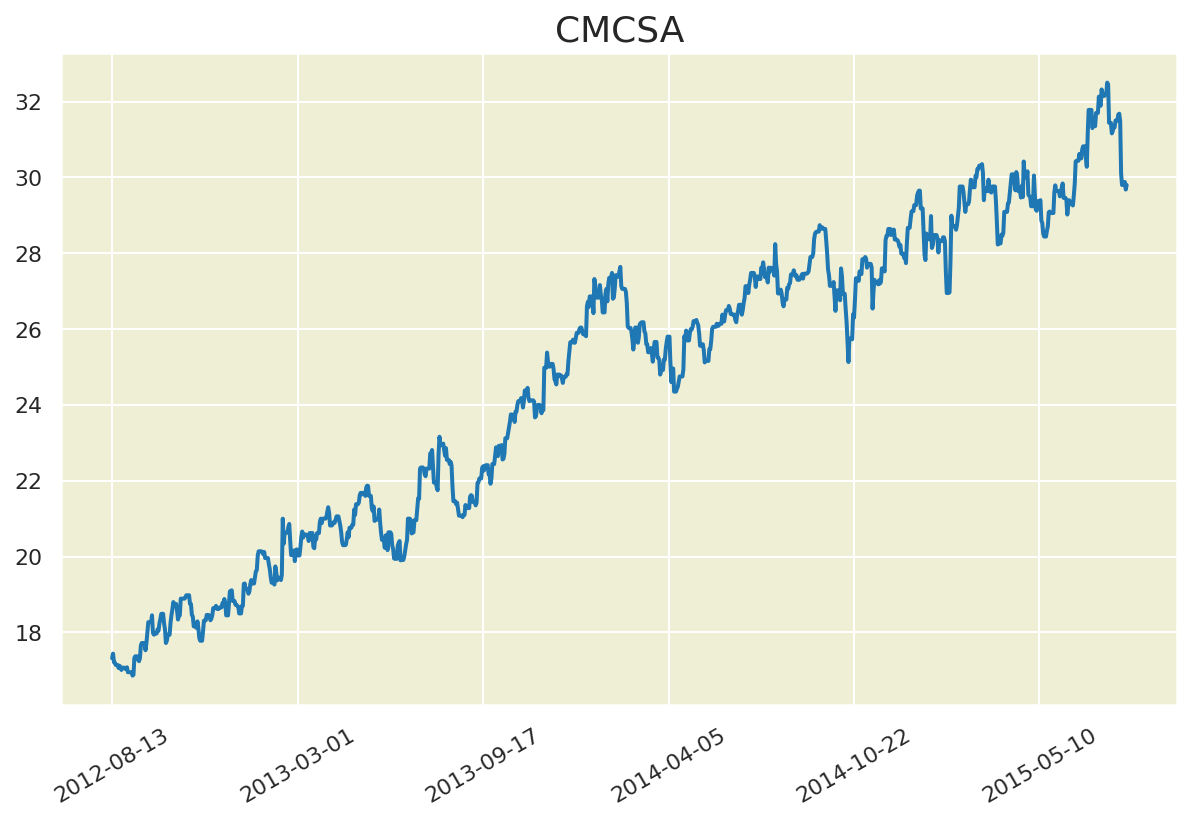

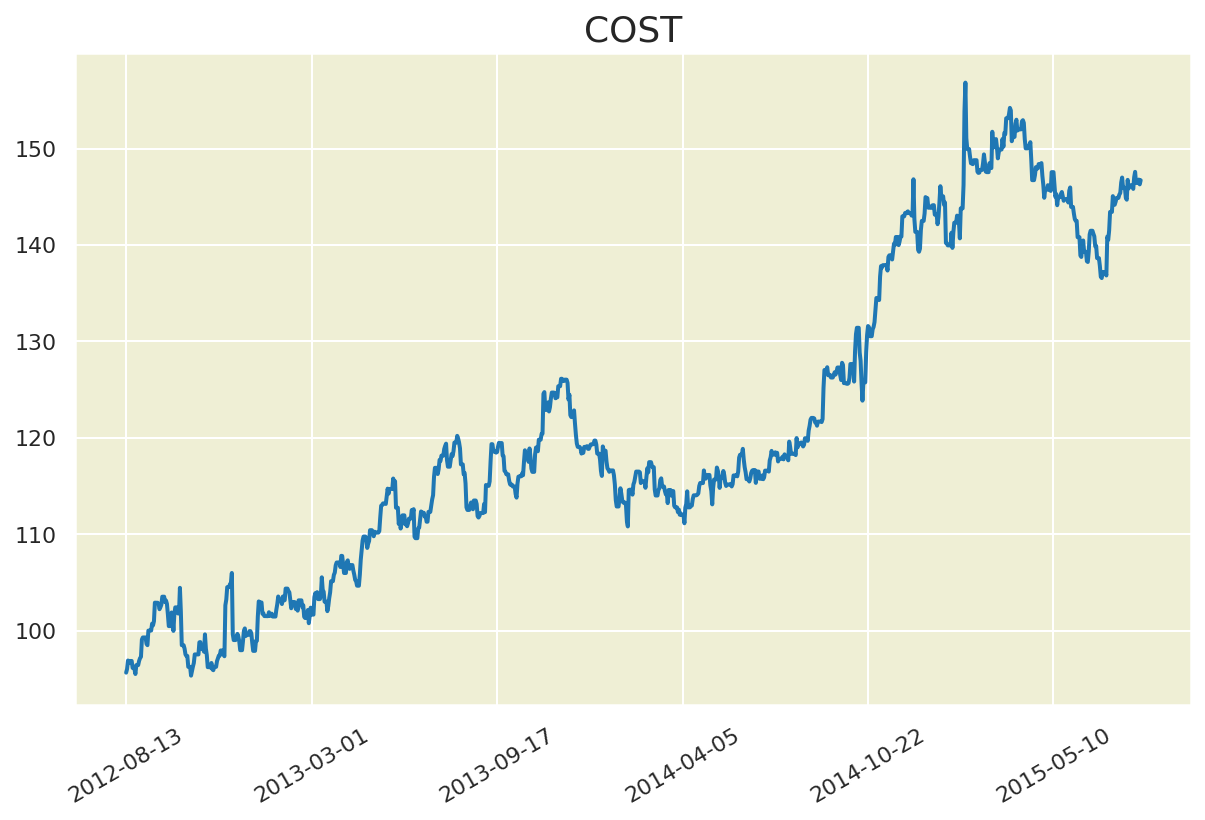

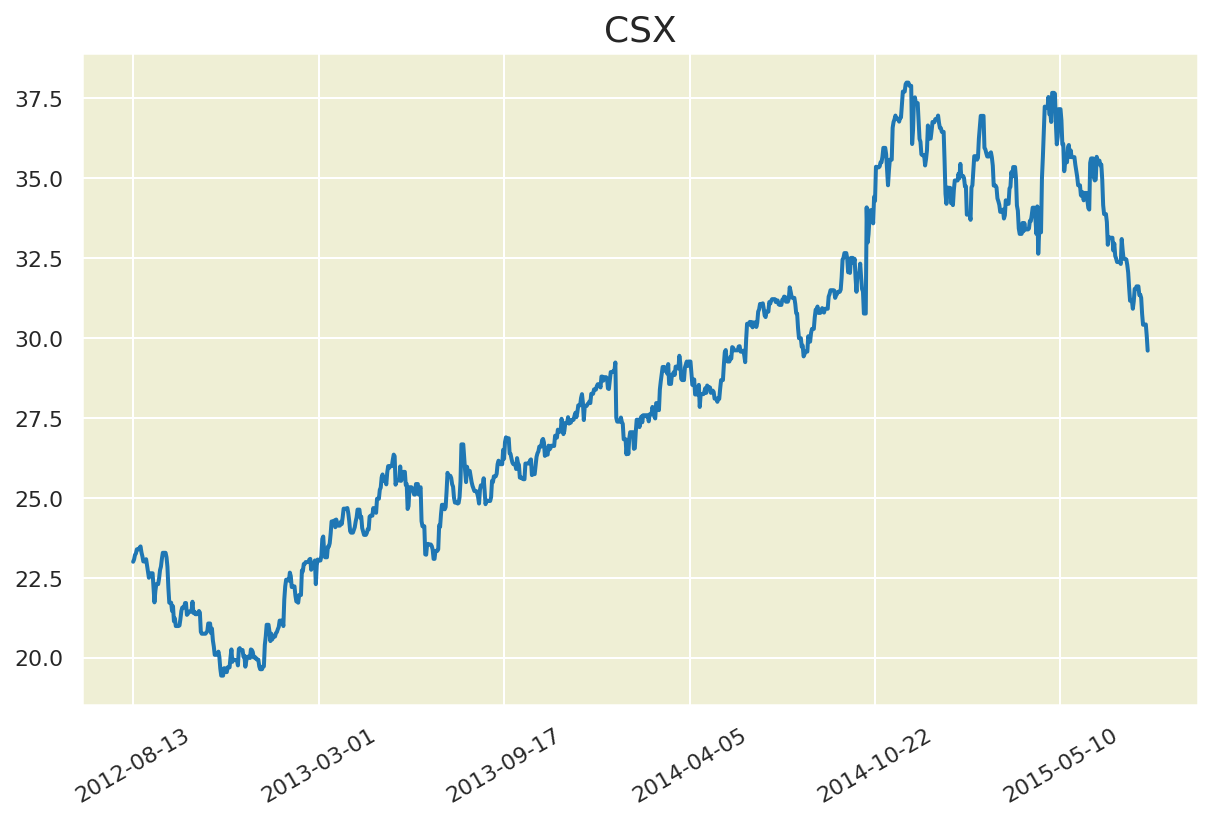

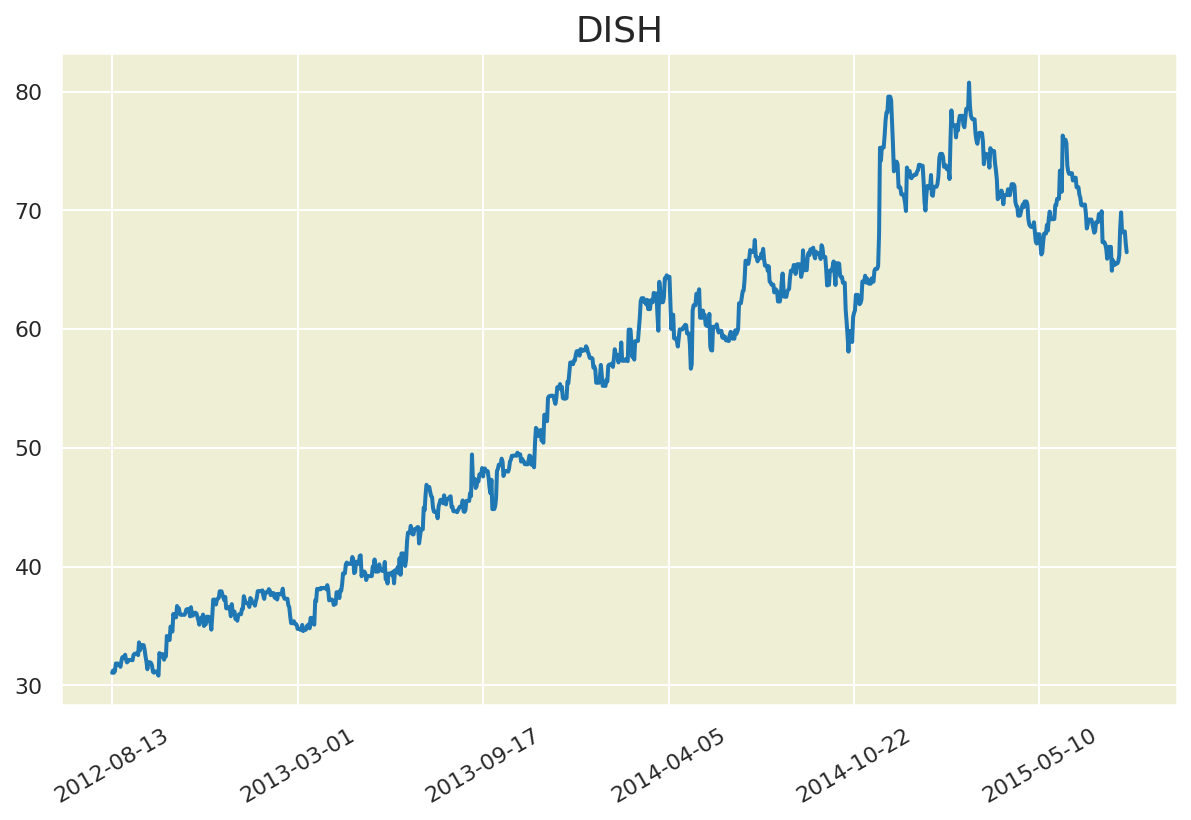

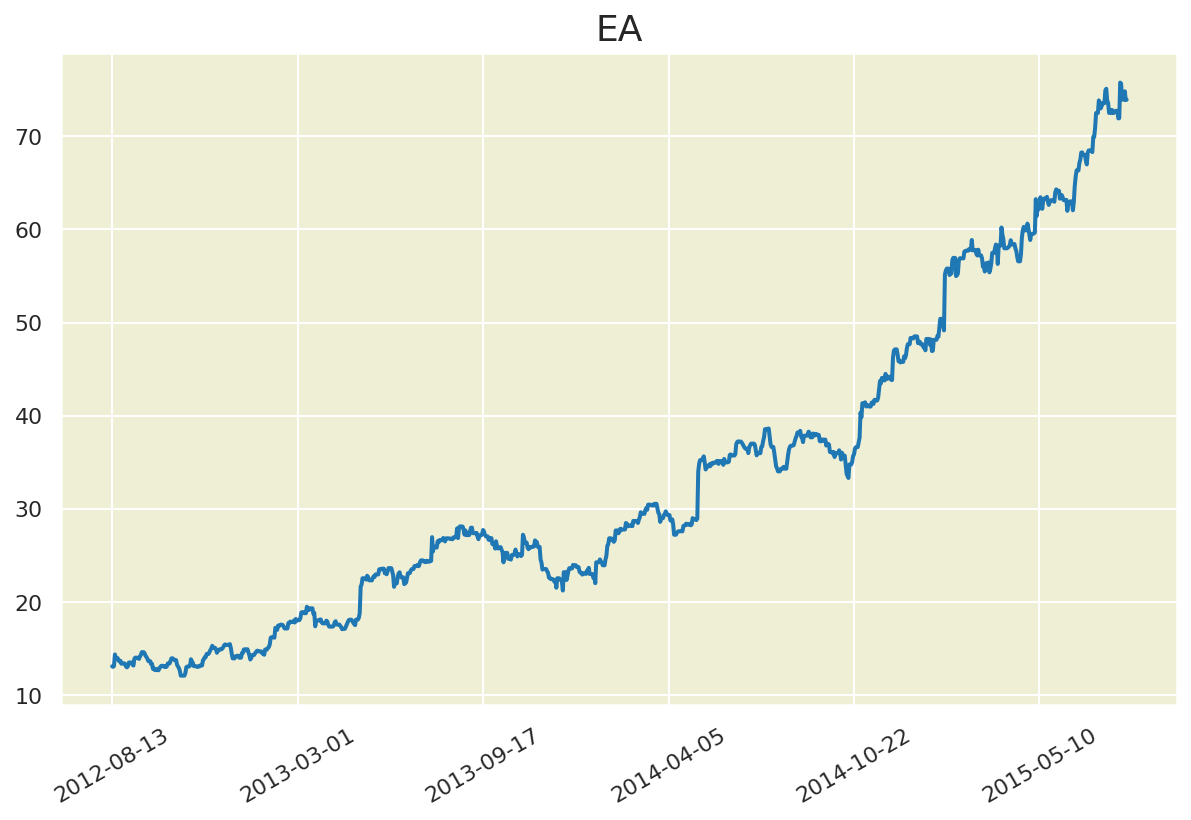

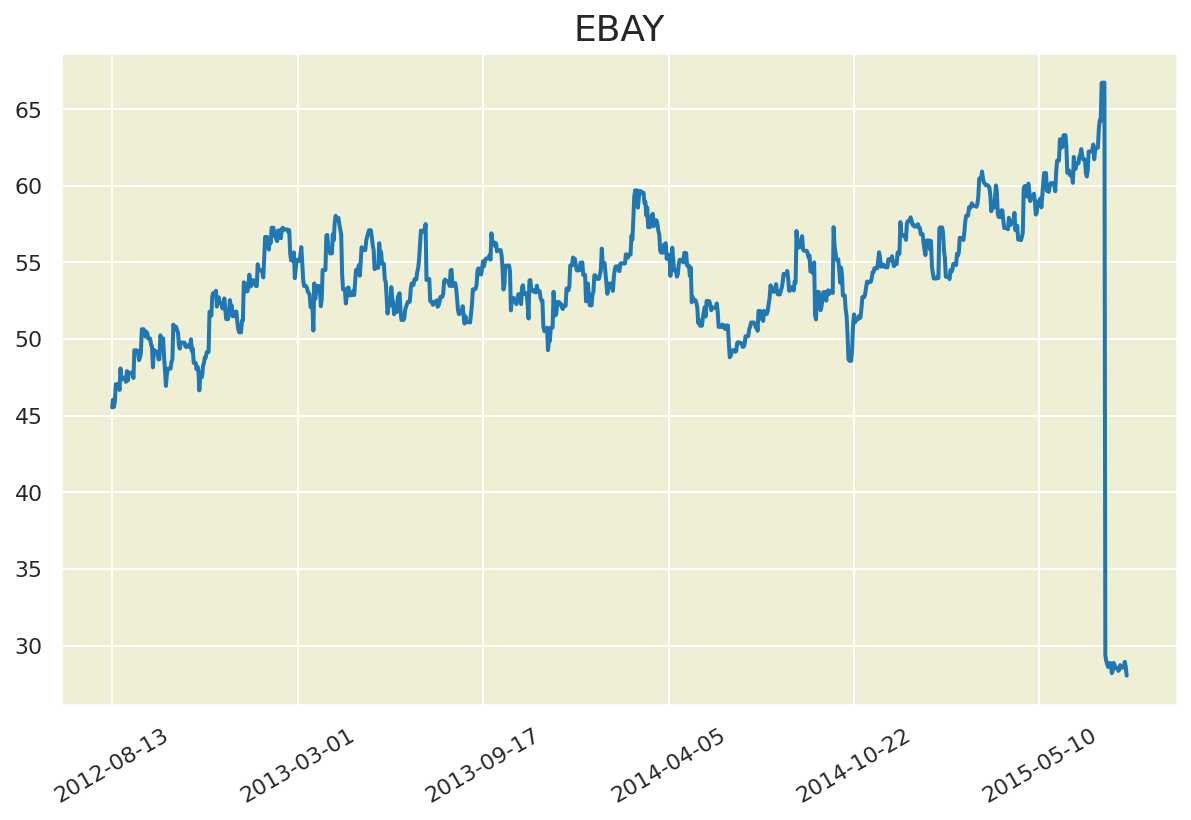

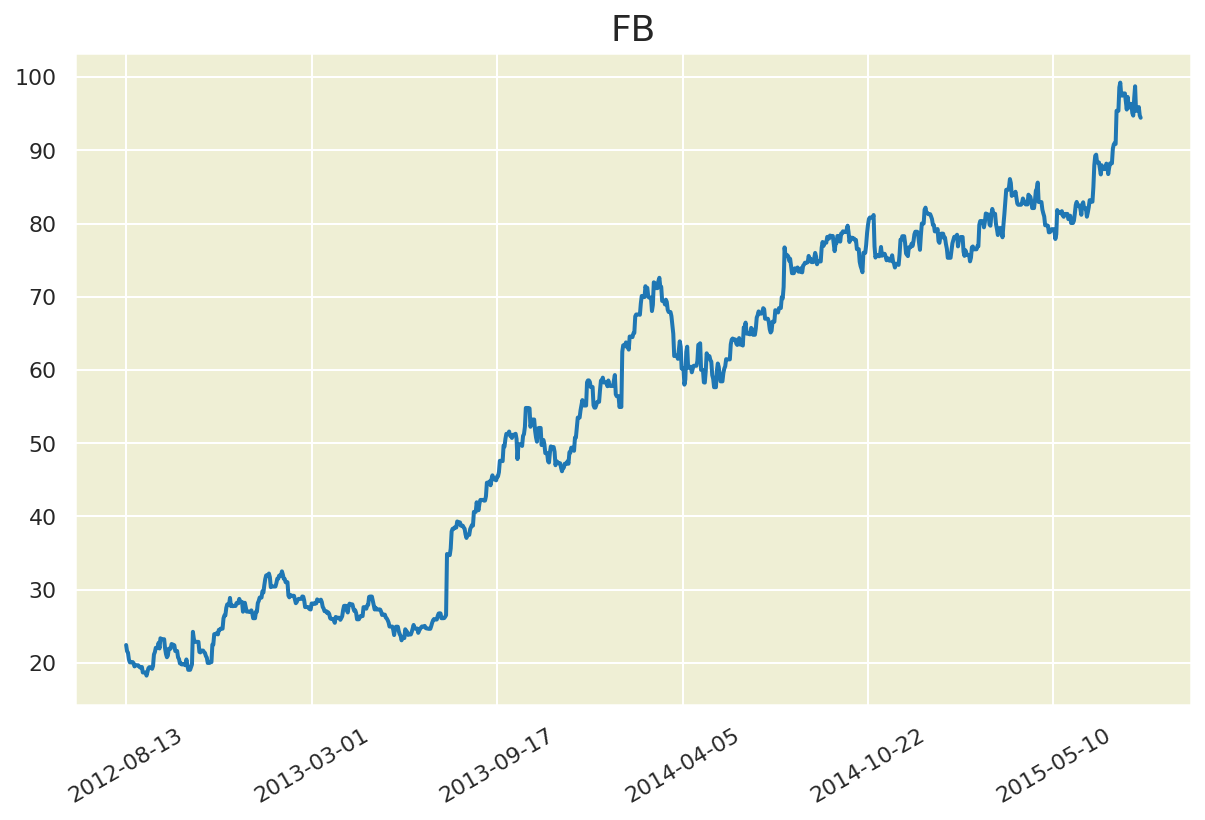

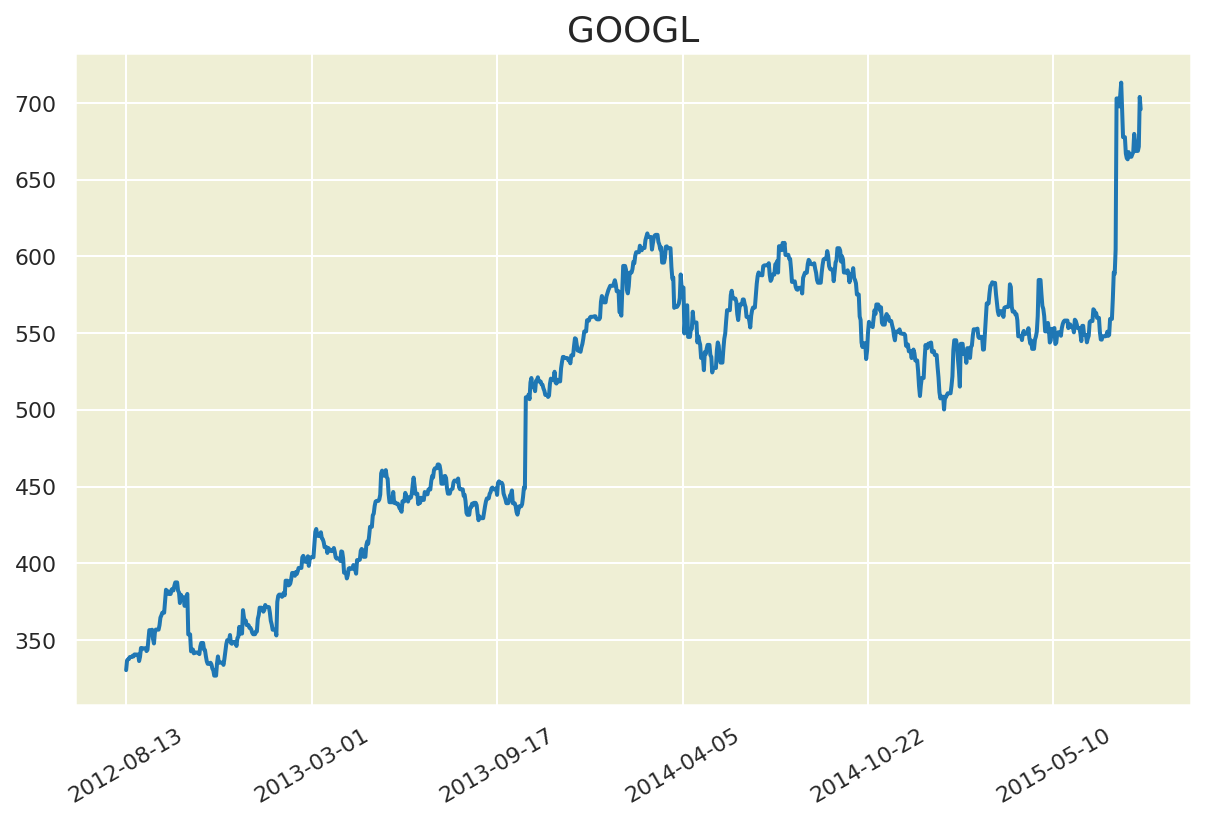

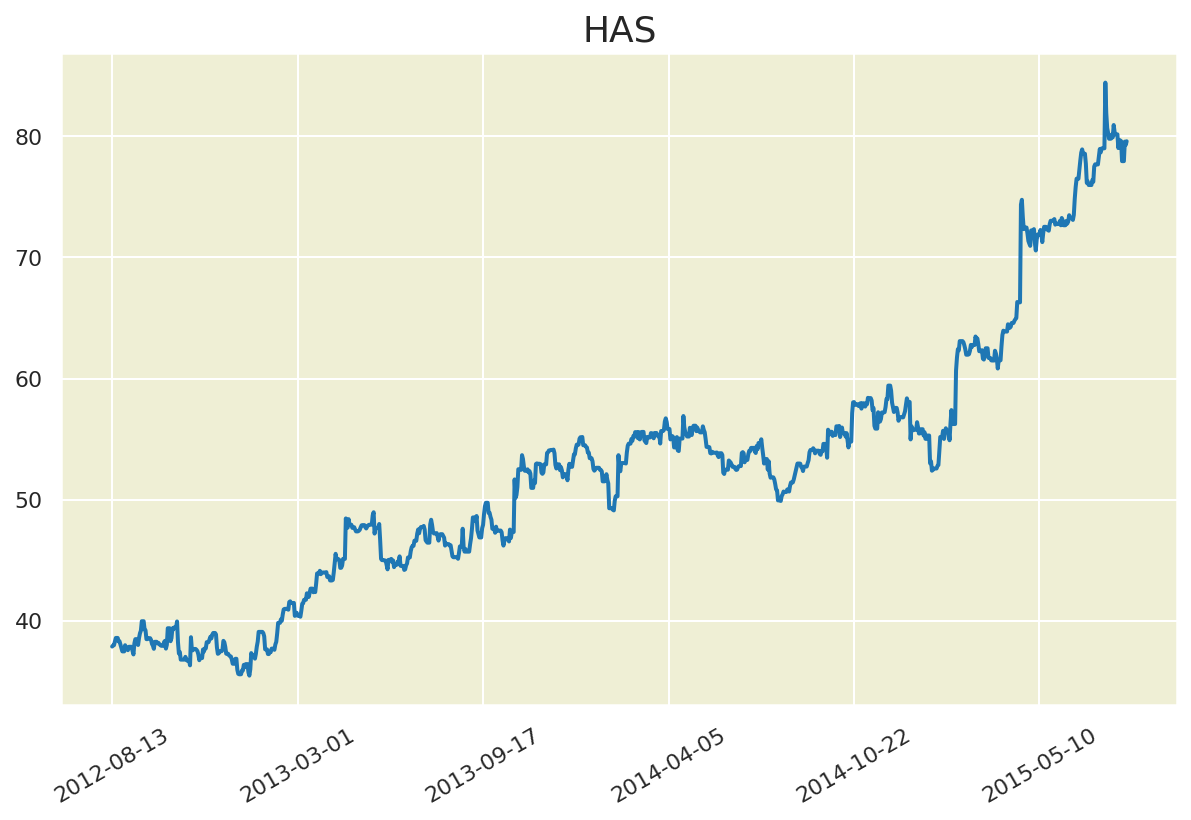

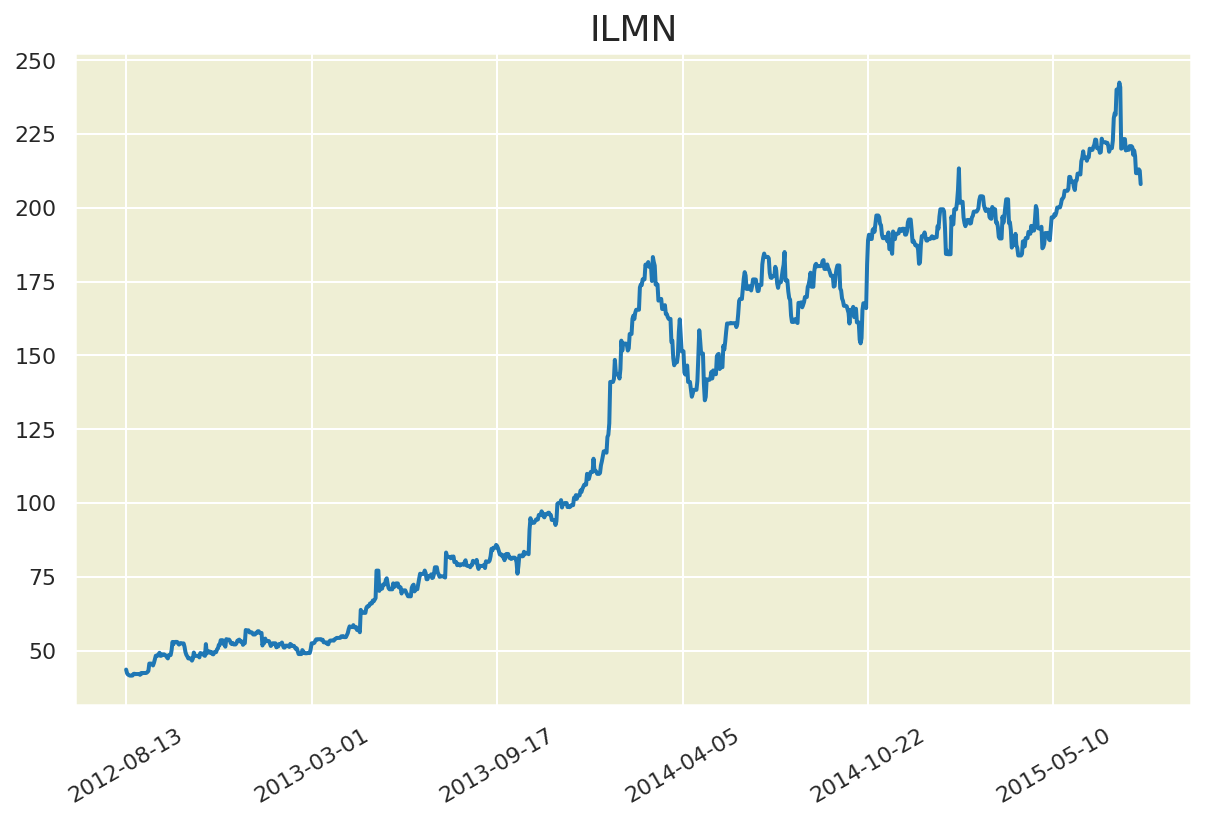

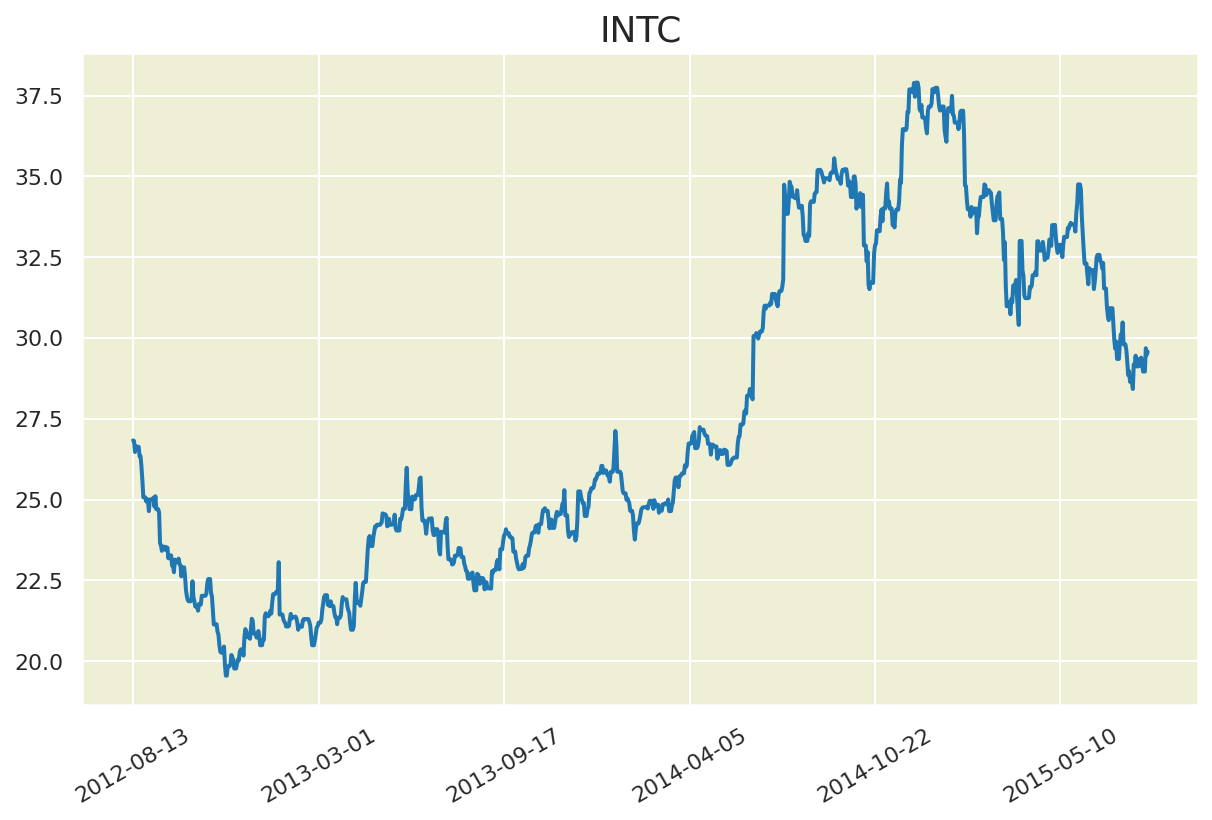

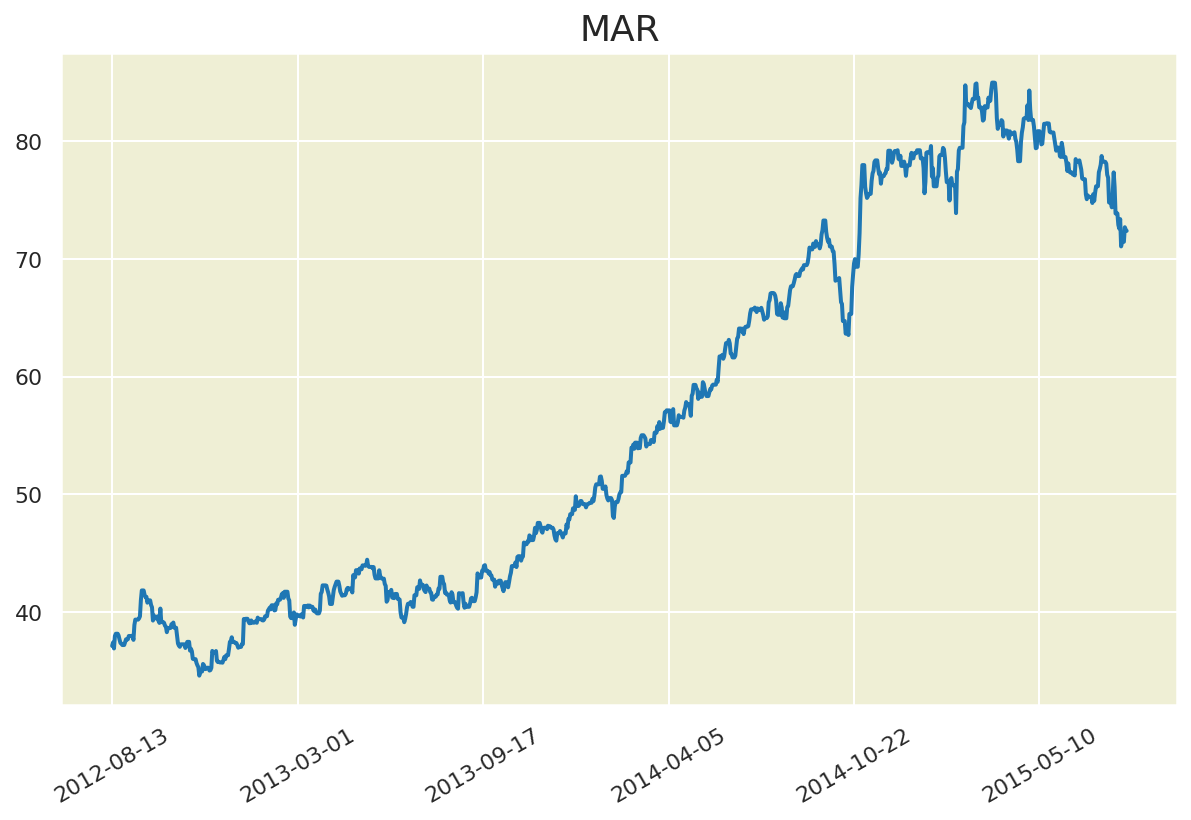

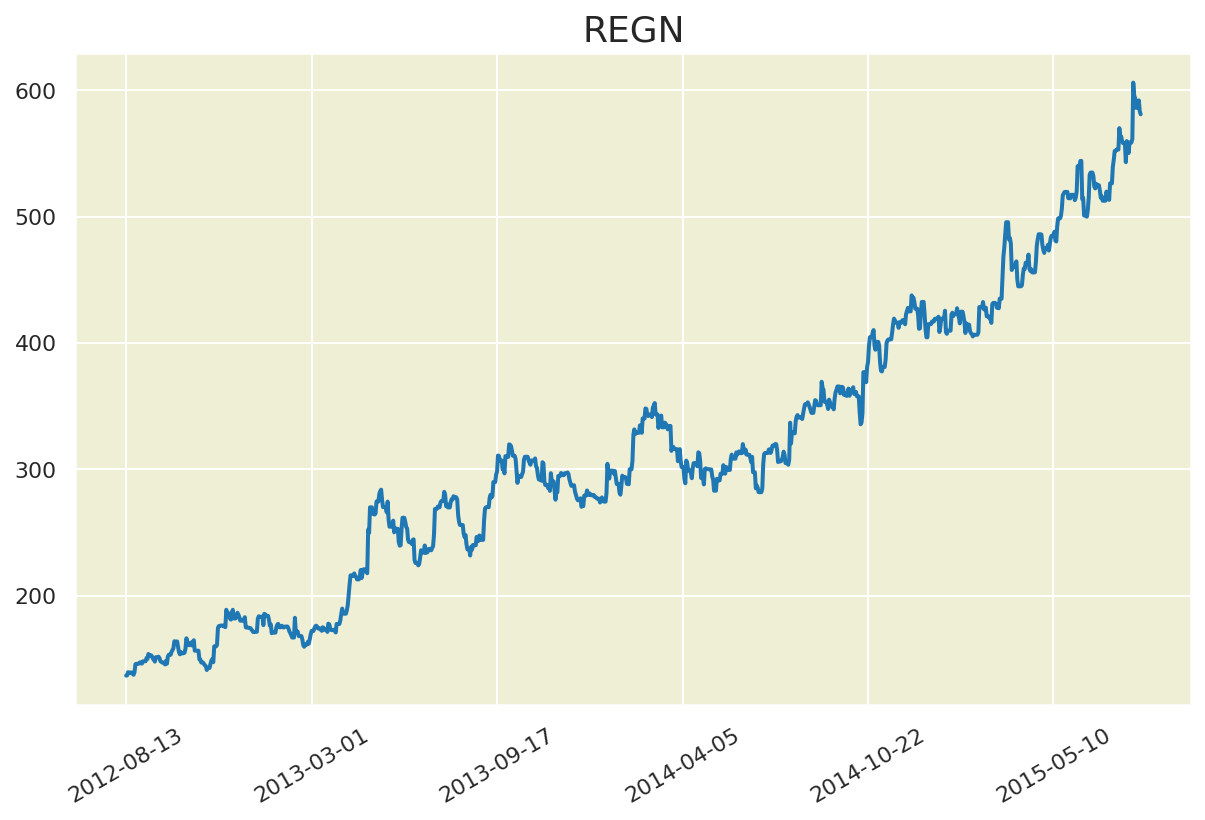

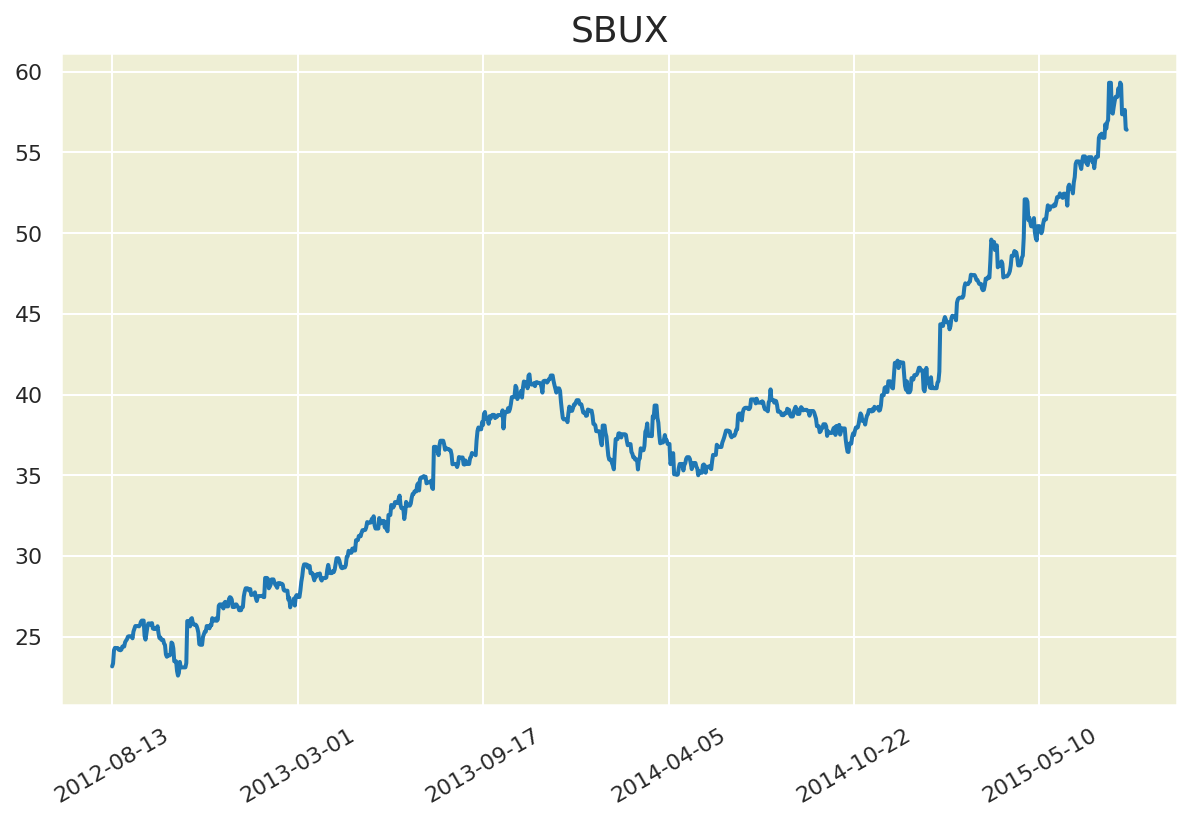

In [6]:

nb_classes = len(target_stocks) + 1

# visualize stock prices
if True:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()



In [9]:

###import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path,test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN
tf.__version__

Using Theano backend.


'1.15.0'

In [10]:


# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

models = []
model_names = []
window_length_lst = [3]
predictor_type_lst = ['lstm']
use_batch_norm = True


# instantiate environment, 16 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=True)
            models.append(ddpg_model)



Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



2022-04-23 10:24:41.916914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-23 10:24:41.938006: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-04-23 10:24:41.938026: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: acalle
2022-04-23 10:24:41.938031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: acalle
2022-04-23 10:24:41.938087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-23 10:24:41.938104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-23 10:24:41.938108: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-23 10:24:41.939044: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU 


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_3/batch_norm/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading lstm_window_3_batch_norm/LSTM/lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: lstm_window_3_batch_norm/LSTM/lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Matrix
Loading lstm_window_3_batch_norm/LSTM/lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: lstm_window_3_batch_norm/LSTM/lstm_window_3_batch_norm/LSTM/BasicLSTMCell/Linear/Bias
Loading lstm_window_3_batch_norm/FullyConnected/W:0 from checkpoint. Name: lstm_window_3_batch_norm/FullyConnected/W
Loading lstm_window_3_batch_norm/FullyConnected/b:0 from checkpoint. Name: lstm_window_3_batch_norm/FullyConnected/b
Loading lstm_window_3_batch_norm/BatchNormalization/beta:0 from checkpoint. Name: lstm_window_3_batch_norm/BatchNo

In [11]:

# create a second dataset for testing that contains different stocks from training stocks shown above
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
print('second stock dataset', abbreviation)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation


(16, 1825, 4)
second stock dataset ['FOX', 'FISV', 'EXPE', 'FAST', 'ESRX', 'DLTR', 'CTSH', 'CSCO', 'QCOM', 'PCLN', 'CELG', 'AMGN', 'WFM', 'WDC', 'NVDA', 'STX']


In [12]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv

<Figure size 720x432 with 0 Axes>

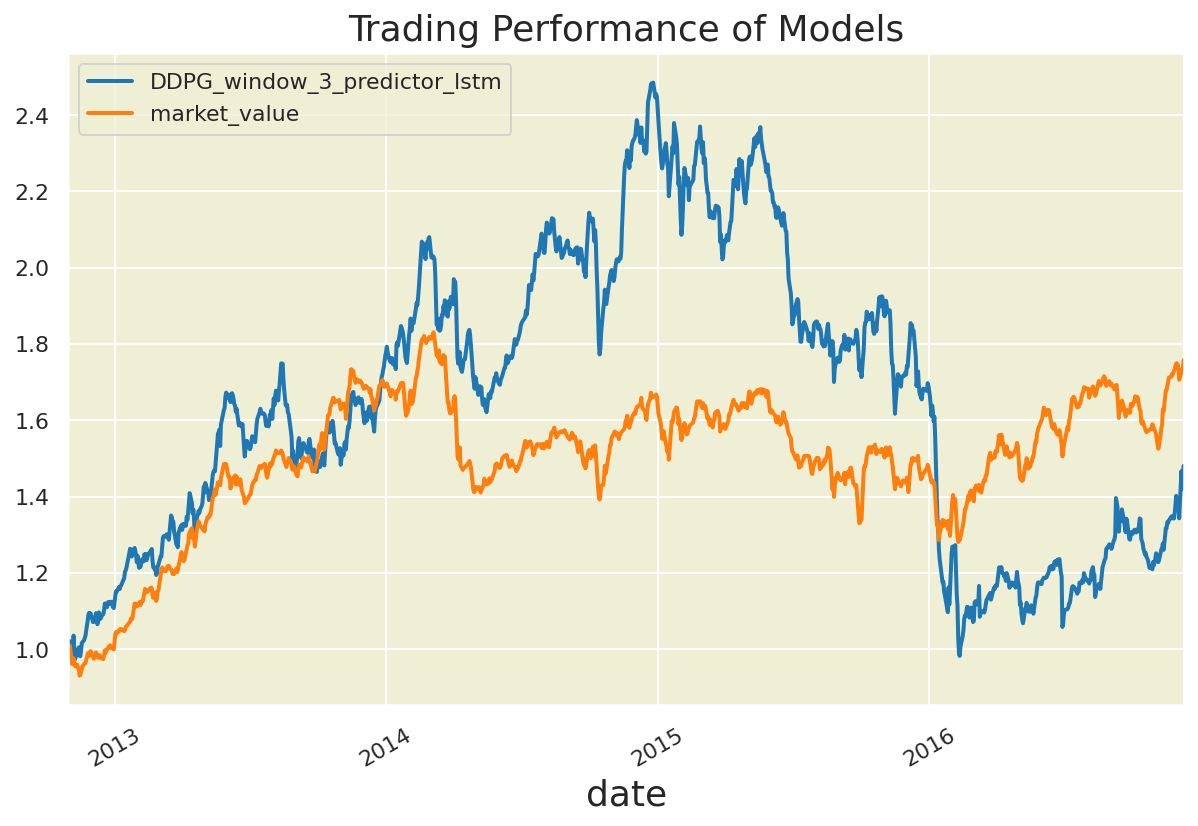

In [13]:
# evaluate the model with dates seen in training but from the second different stocks dataset
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:1], steps=1500, 
                              sample_start_date='2012-10-30')

observations_list, info_list, actions_list, df_performance = test_model_multiple(env, models[:1])


<Figure size 720x432 with 0 Axes>

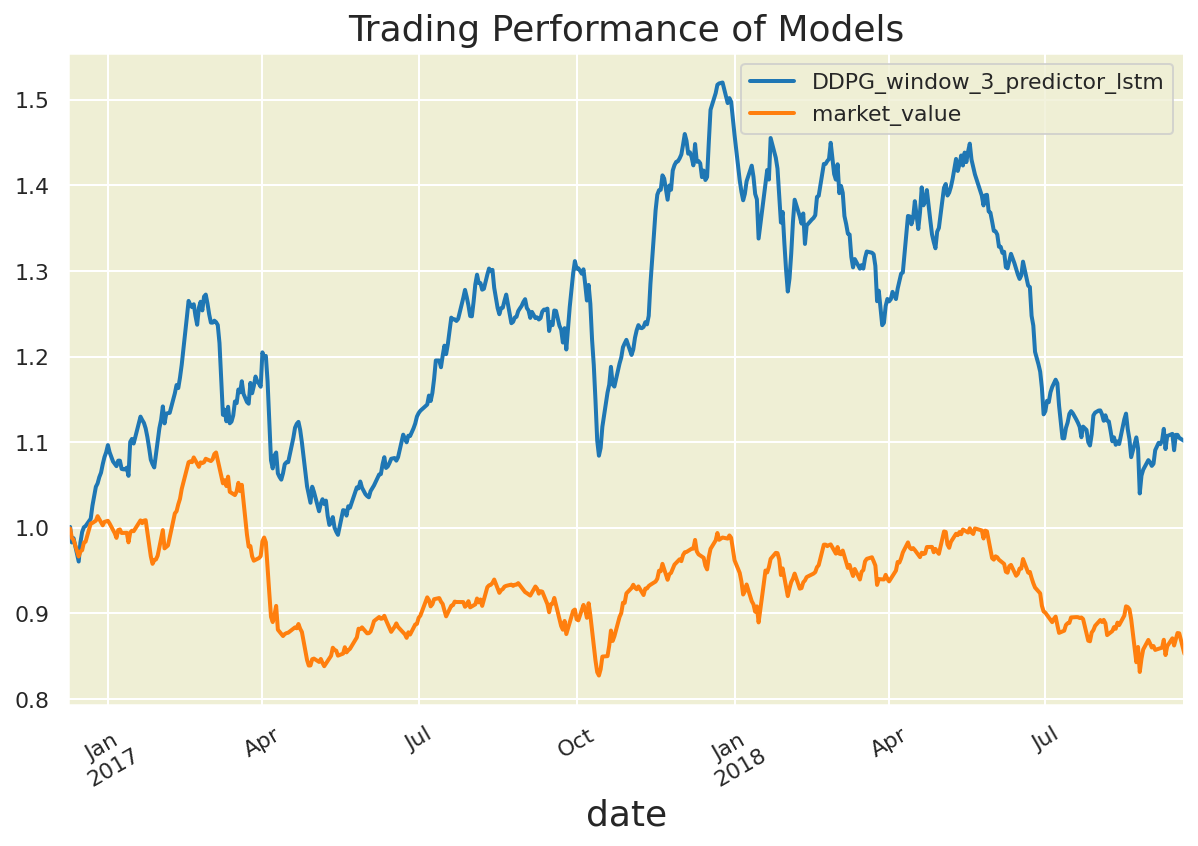

In [14]:

# evaluate the model with unseen dates from the second different stocks dataset, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:1], steps=650, 
                              start_idx=num_training_time, sample_start_date='2016-12-8')

observations_list, info_list, actions_list, df_performance = test_model_multiple(env, models[:1])



In [15]:
import pandas as pd
actions_list = np.array(actions_list).squeeze(1)
abbreviation.insert(0,'blank')
df_actions = pd.DataFrame(actions_list, columns=abbreviation)
print('stock symbols: ', abbreviation)#[ np.argmax(actions_list[0]) -1])
maxValueIndexObj = df_actions.idxmax(axis=1)
print(' ')
print("Stock selected by the agent for each step :")
print(maxValueIndexObj)


stock symbols:  ['blank', 'FOX', 'FISV', 'EXPE', 'FAST', 'ESRX', 'DLTR', 'CTSH', 'CSCO', 'QCOM', 'PCLN', 'CELG', 'AMGN', 'WFM', 'WDC', 'NVDA', 'STX']
 
Stock selected by the agent for each step :
0      CSCO
1       WDC
2       WDC
3       WDC
4       WDC
       ... 
646    CSCO
647    CSCO
648    CSCO
649    CSCO
650    CSCO
Length: 651, dtype: object


In [16]:
df_performance = df_performance.reset_index()
maxValueIndexObj.name="stocks"
result = pd.concat([ maxValueIndexObj, df_performance.reindex(maxValueIndexObj.index)], axis=1)

print(result)

    stocks       date  DDPG_window_3_predictor_lstm  market_value
0     CSCO 2016-12-09                      0.996865      0.993631
1      WDC 2016-12-10                      1.000980      0.999179
2      WDC 2016-12-11                      0.982847      0.988202
3      WDC 2016-12-12                      0.987859      0.985856
4      WDC 2016-12-13                      0.978653      0.979342
..     ...        ...                           ...           ...
646   CSCO 2018-09-16                      1.108551      0.877026
647   CSCO 2018-09-17                      1.105134      0.876713
648   CSCO 2018-09-18                      1.103838      0.868662
649   CSCO 2018-09-19                      1.102543      0.860686
650   CSCO 2018-09-20                      1.101249      0.852783

[651 rows x 4 columns]


array(['CSCO', 'WDC'], dtype=object)

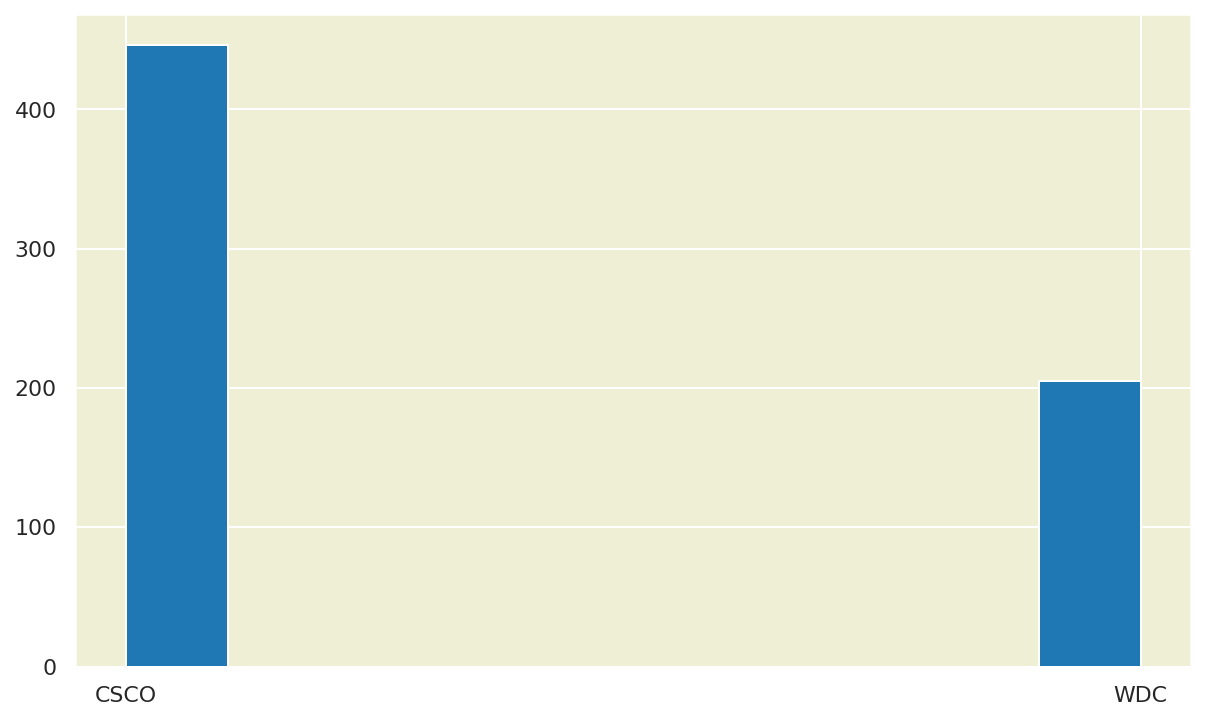

In [17]:
# histogram of the stocks selected by the agent
maxValueIndexObj.hist()
maxValueIndexObj.unique()

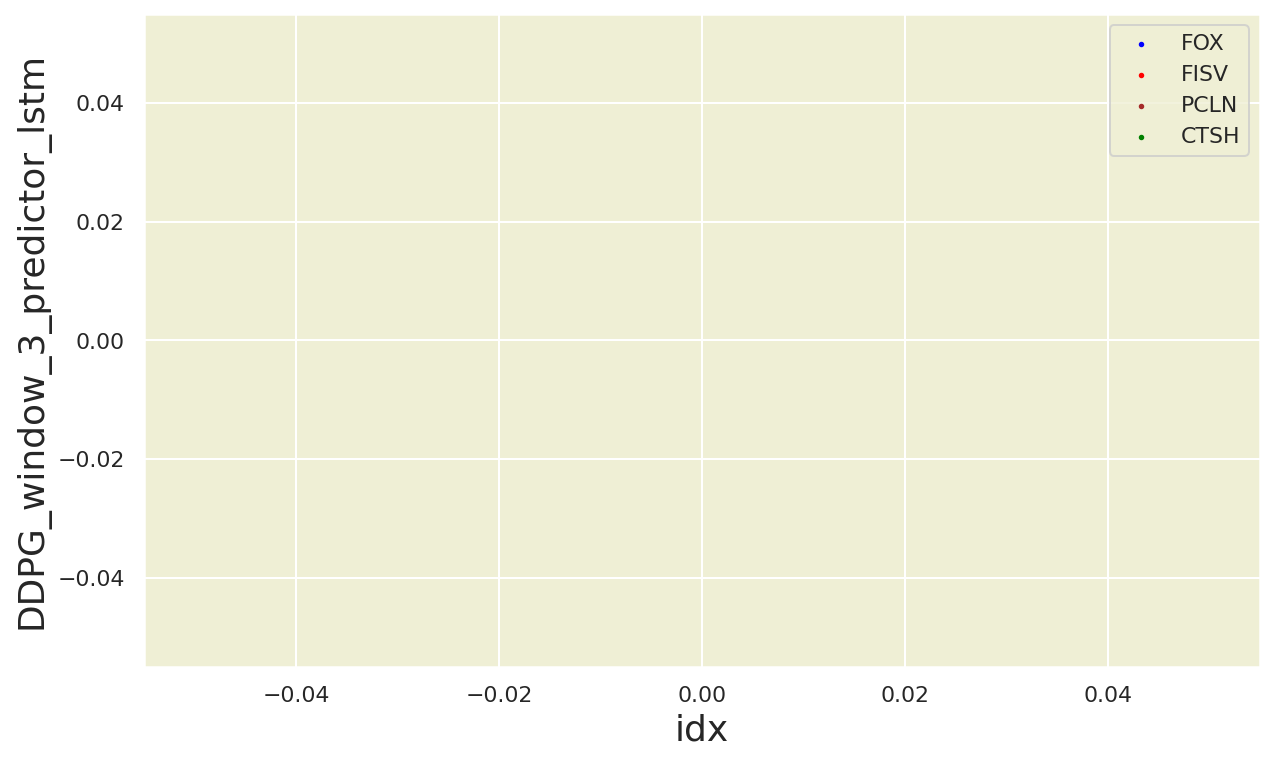

In [18]:
# show the stocks selected by the agent at each step in the test period
import matplotlib.pyplot as plt
ax = plt.gca()

df_fox = result.loc[result['stocks'] == 'FOX']
df_ctsh = result.loc[result['stocks'] == 'CTSH']
df_pcln = result.loc[result['stocks'] == 'PCLN']
df_fisv = result.loc[result['stocks'] == 'FISV']
df_fox.index.name = 'idx'
df_ctsh.index.name = 'idx'
df_pcln.index.name = 'idx'
df_fisv.index.name = 'idx'


df= df_fox.reset_index()
df.plot(kind='scatter',x='idx',y='DDPG_window_3_predictor_lstm', color='blue', ax=ax, s=3, label='FOX')
df= df_fisv.reset_index()
df.plot(kind='scatter',x='idx', y='DDPG_window_3_predictor_lstm', color='red', ax=ax, s=3,label='FISV')
df= df_pcln.reset_index()
df.plot(kind='scatter',x='idx', y='DDPG_window_3_predictor_lstm', color='brown', ax=ax, s=3,label='PCLN')
df= df_ctsh.reset_index()
df.plot(kind='scatter',x='idx', y='DDPG_window_3_predictor_lstm', color='green', ax=ax, s=3,label='CTSH')
ax.legend()

plt.show()
